In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

### data

In [2]:
landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')

In [3]:
landmarks_frame[65:66]

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99


In [4]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
img_name

'person-7.jpg'

In [5]:
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks

array([32, 65, 33, 76, 34, 86, 34, 97, 37, 107, 41, 116, 50, 122, 61, 126,
       72, 127, 83, 126, 95, 123, 107, 119, 115, 111, 118, 101, 120, 91,
       122, 80, 122, 68, 39, 52, 45, 46, 53, 44, 61, 46, 68, 49, 82, 49,
       90, 45, 98, 44, 106, 46, 112, 52, 74, 57, 74, 63, 74, 69, 74, 75,
       67, 83, 70, 84, 74, 85, 78, 84, 82, 83, 47, 61, 51, 57, 58, 57, 63,
       61, 57, 63, 51, 63, 87, 62, 93, 58, 98, 58, 103, 61, 99, 63, 93,
       63, 55, 98, 63, 96, 70, 94, 75, 95, 80, 94, 86, 95, 94, 99, 86,
       103, 79, 105, 74, 105, 69, 105, 62, 103, 58, 99, 70, 98, 74, 98,
       79, 98, 91, 99, 79, 99, 74, 99, 69, 99], dtype=object)

In [6]:
print('before shape', landmarks.shape)
landmarks = landmarks.astype('float').reshape(-1, 2)
print('after shape', landmarks.shape)
print('First 4 Landmarks: {}'.format(landmarks[:4]))

before shape (136,)
after shape (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


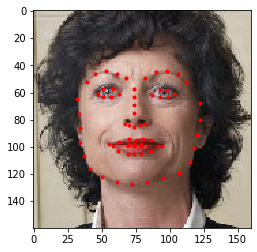

In [7]:
# show function
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('./data/faces', img_name)), landmarks)
plt.show()


### Dataset 
- torch.utils.data.Dataset is an abstract class 
- override following methods
  + __len__ : len(dataset) returns the size of the dataset 
  + __getitem__ : indexing dataset[i] can be used to get ith sample
- Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir 
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # torch.Tensor -> list
        
        img_name= os.path.join(self.root_dir,
                               self.landmarks_frame.iloc[idx, 0]) # .jpg
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks]) # np.array(list(dataframe))
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                   root_dir='./data/faces/')

0 (324, 215, 3) (68, 2)


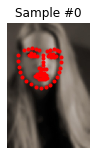

1 (500, 333, 3) (68, 2)


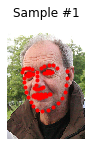

2 (250, 258, 3) (68, 2)


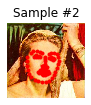

3 (434, 290, 3) (68, 2)


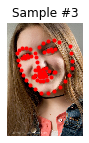

In [10]:
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

### Transforms
- Images are different size. but neural networks expect the images of fixed size. Therefore, we need to preprocessing code
  + Rescale: to scale the image 
  + RandomCrop: to crop from image randomly. This is data augmentation
  + ToTensor: to convert numpy images to torch image
we will write them as callable classes instead of simple functions os that parameters of the transform need not be passed everytime it's called. 
For this, we need to implement __call__ method and if required, __init__ method.
```
transform = Transform(params)
transformed_sample = transform(sample)
```

In [11]:
class Rescale(object):
    """
    Rescale the image in a sample to a given size.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is matched to output_size. 
        If int, smaller of imaged edges is matched to output_size keeping aspect ration the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images.
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}
    
    

In [12]:
class RandomCrop(object):
    """
    Crop randomly the image in a sample.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms
- we want to rescale the shorter side of the image to 256 
- randomly crop a square of size 224 from it 
- torchvision.transforms.Compose

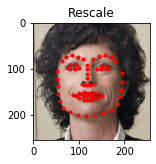

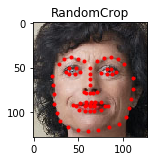

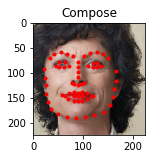

In [14]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fit = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

### Iterating through the dataset

In [17]:
transformed_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                           root_dir='./data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### torch.utils.data.DataLoader 
- batching the data
- shuffling the data
- load the data in parallel using multiprocessing workers

In [24]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [25]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i+1) * grid_border_size, 
                    landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


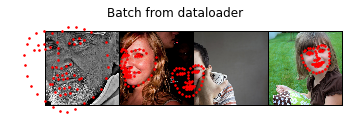

In [27]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())

    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

### Afterword: torchvision
- torchvision package provieds some common datasets and transforms

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.409],
                         std=[0.299, 0.224, 0.225])

])

hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                          transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                            batch_size=4, shuffle=True, num_workers=4)